In [2]:
import numpy as np
import casadi as ca
import jax
import jax.numpy as jnp

In [3]:
theta_1 = theta_2 = theta_3 = 2.25e-4
c = np.array([2.697,  2.66,  3.05, 2.86])*1e-3
d = np.array([6.78,  8.01,  8.82])*1e-5
tau = 1e-2

def casadi_model(x,u):
    phi_1= x[0,:]
    phi_2= x[1,:]
    phi_3= x[2,:]
    dphi_1= x[3,:]
    dphi_2= x[4,:]
    dphi_3= x[5,:]
    phi_1_m= x[6,:]
    phi_2_m= x[7,:]

    phi_m_1_set = u[0,:]
    phi_m_2_set = u[1,:]

    return ca.vertcat(
        dphi_1,
        dphi_2,
        dphi_3,
        -c[0]/theta_1*(phi_1-phi_1_m)-c[1]/theta_1*(phi_1-phi_2)-d[0]/theta_1*dphi_1,
        -c[1]/theta_2*(phi_2-phi_1)-c[2]/theta_2*(phi_2-phi_3)-d[1]/theta_2*dphi_2,
        -c[2]/theta_3*(phi_3-phi_2)-c[3]/theta_3*(phi_3-phi_2_m)-d[2]/theta_3*dphi_3,
        1/tau*(phi_m_1_set - phi_1_m),
        1/tau*(phi_m_2_set - phi_2_m)
    )


In [4]:

horizon = 50
nx = 8
nu = 2
dt = 0.05
x0 = np.pi*np.array([1, 1, -1.5, 1, -1, 1, 0, 0]).reshape(-1,1)

option = {}
option['max_iter']=10000
#option["hessian_approximation"] = "limited-memory"


#option['print_level']=0
opti_casadi = ca.Opti()
x = opti_casadi.variable(nx,horizon+1)
u = opti_casadi.variable(nu,horizon)

phi_1= x[0,:]
phi_2= x[1,:]
phi_3= x[2,:]
dphi_1= x[3,:]
dphi_2= x[4,:]
dphi_3= x[5,:]
phi_1_m= x[6,:]
phi_2_m= x[7,:]

phi_m_1_set = u[0,:]
phi_m_2_set = u[1,:]

k1 = casadi_model(x[:,0:-1],u)
k2 = casadi_model(x[:,0:-1]+dt/2*k1,u)
k3 = casadi_model(x[:,0:-1]+dt/2*k2,u)
k4 = casadi_model(x[:,0:-1]+dt*k3,u)

opti_casadi.minimize(ca.dot(phi_1,phi_1)+ca.dot(phi_2,phi_2)+ca.dot(phi_3,phi_3)
              +0.001*ca.dot(phi_m_1_set,phi_m_1_set)+0.1*ca.dot(phi_m_2_set,phi_m_2_set)
              +0.001*ca.dot(phi_1_m,phi_1_m)+0.1*ca.dot(phi_2_m,phi_2_m))

opti_casadi.subject_to(x[:,1:] == x[:,0:-1]+dt/6*(k1+2*k2+2*k3+k4))

opti_casadi.subject_to(x[:,0]==x0)

opti_casadi.subject_to(opti_casadi.bounded(-2*ca.pi,x[0:2,:],2*ca.pi))
opti_casadi.subject_to(opti_casadi.bounded(-2*ca.pi,x[6:,:],2*ca.pi))
opti_casadi.subject_to(opti_casadi.bounded(-2*ca.pi,u,2*ca.pi))


opti_casadi.solver("ipopt",{},option)

try:
    casadi_sol = opti_casadi.solve()
    casadi_phi_1 = casadi_sol.value(phi_1)
    casadi_phi_2 = casadi_sol.value(phi_2)
    casadi_phi_3 = casadi_sol.value(phi_3)
except Exception as e:
    print(e)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3008
Number of nonzeros in inequality constraint Jacobian.:      304
Number of nonzeros in Lagrangian Hessian.............:      355

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

In [7]:

from jax_casadi_callback import JaxCasadiCallbackJacobian

option = {}
option['max_iter']=10000
#option["hessian_approximation"] = "limited-memory"

casadi_option={'print_time':True,'enable_reverse': True}

def jax_model(x):
    x=np.reshape(x,(-1,))
    phi_1= x[0]
    phi_2= x[1]
    phi_3= x[2]
    dphi_1= x[3]
    dphi_2= x[4]
    dphi_3= x[5]
    phi_1_m= x[6]
    phi_2_m= x[7]

    phi_m_1_set = x[8]
    phi_m_2_set = x[9]

    
    return jnp.asarray([
        dphi_1,
        dphi_2,
        dphi_3,
        -c[0]/theta_1*(phi_1-phi_1_m)-c[1]/theta_1*(phi_1-phi_2)-d[0]/theta_1*dphi_1,
        -c[1]/theta_2*(phi_2-phi_1)-c[2]/theta_2*(phi_2-phi_3)-d[1]/theta_2*dphi_2,
        -c[2]/theta_3*(phi_3-phi_2)-c[3]/theta_3*(phi_3-phi_2_m)-d[2]/theta_3*dphi_3,
        1/tau*(phi_m_1_set - phi_1_m),
        1/tau*(phi_m_2_set - phi_2_m)]
    ).reshape(-1,1)

#vmap_model = jax.vmap(jax_model,in_axes=0,out_axes=0)

jax_model_f = JaxCasadiCallbackJacobian('jax_model',jax_model,nx+nu,nx,horizon+1)




test_x = ca.MX(nx+nu,horizon+1)
jac_f = ca.Function('f_jac',[test_x],[ca.jacobian(jax_model_f(test_x),test_x)])
dm_y = ca.DM_rand(nx+nu,horizon+1)

it1 = jax_model_f.callback.its
callback_jac_v = jac_f(dm_y)
it2 = jax_model_f.callback.its

print(it1)
print(it2)
jax_model_f.callback.total_N = it2-it1



#option['print_level']=0
opti_jax = ca.Opti()
x = opti_jax.variable(nx+nu,horizon+1)
#u = opti_jax.variable(nu,horizon)

phi_1= x[0,:]
phi_2= x[1,:]
phi_3= x[2,:]
dphi_1= x[3,:]
dphi_2= x[4,:]
dphi_3= x[5,:]
phi_1_m= x[6,:]
phi_2_m= x[7,:]

phi_m_1_set = x[8,:]
phi_m_2_set = x[9,:]

# k1 = casadi_model(x[:,0:-1],u)
# k2 = casadi_model(x[:,0:-1]+dt/2*k1,u)
# k3 = casadi_model(x[:,0:-1]+dt/2*k2,u)
# k4 = casadi_model(x[:,0:-1]+dt*k3,u)

opti_jax.minimize(ca.dot(phi_1,phi_1)+ca.dot(phi_2,phi_2)+ca.dot(phi_3,phi_3)
              +0.001*ca.dot(phi_m_1_set,phi_m_1_set)+0.1*ca.dot(phi_m_2_set,phi_m_2_set)
              +0.001*ca.dot(phi_1_m,phi_1_m)+0.1*ca.dot(phi_2_m,phi_2_m))

opti_jax.subject_to(x[0:8,1:] == x[0:8,0:-1]+dt*jax_model_f(x[:,0:-1]))

opti_jax.subject_to(x[0:8,0]==x0)

opti_jax.subject_to(x[8:,-1]==0)


opti_jax.subject_to(opti_jax.bounded(-2*ca.pi,phi_1,2*ca.pi))
opti_jax.subject_to(opti_jax.bounded(-2*ca.pi,phi_2,2*ca.pi))
opti_jax.subject_to(opti_jax.bounded(-2*ca.pi,phi_3,2*ca.pi))

opti_jax.subject_to(opti_jax.bounded(-2*ca.pi,phi_1_m,2*ca.pi))
opti_jax.subject_to(opti_jax.bounded(-2*ca.pi,phi_1_m,2*ca.pi))

opti_jax.subject_to(opti_jax.bounded(-ca.pi,phi_m_1_set,ca.pi))
opti_jax.subject_to(opti_jax.bounded(-ca.pi,phi_m_2_set,ca.pi))

opti_jax.solver("ipopt",{},option)

try:
    jax_sol = opti_jax.solve()
    jax_phi_1 = opti_jax.value(phi_1)
    jax_phi_2 = opti_jax.value(phi_2)
    jax_phi_3 = opti_jax.value(phi_3)

except Exception as e:
    print(e)

initializing object


AttributeError: 'Callback' object has no attribute 'callback'

In [28]:
def jax_model(x,N,nx,nu):
    x=np.reshape(x,(-1,))
    phi_1= x[0:nx*N:nx]
    phi_2= x[1:nx*N:nx]
    phi_3= x[2:nx*N:nx]
    dphi_1= x[3:nx*N:nx]
    dphi_2= x[4:nx*N:nx]
    dphi_3= x[5:nx*N:nx]
    phi_1_m= x[6:nx*N:nx]
    phi_2_m= x[7:nx*N:nx]

    phi_m_1_set = x[8*N::nu]
    phi_m_2_set = x[8*N+1::nu]

    
    return jnp.asarray([
        dphi_1[0:-1],
        dphi_2[0:-1],
        dphi_3[0:-1],
        -c[0]/theta_1*(phi_1[0:-1]-phi_1_m[0:-1])-c[1]/theta_1*(phi_1[0:-1]-phi_2[0:-1])-d[0]/theta_1*dphi_1[0:-1],
        -c[1]/theta_2*(phi_2[0:-1]-phi_1[0:-1])-c[2]/theta_2*(phi_2[0:-1]-phi_3[0:-1])-d[1]/theta_2*dphi_2[0:-1],
        -c[2]/theta_3*(phi_3[0:-1]-phi_2[0:-1])-c[3]/theta_3*(phi_3[0:-1]-phi_2_m[0:-1])-d[2]/theta_3*dphi_3[0:-1],
        1/tau*(phi_m_1_set - phi_1_m[0:-1]),
        1/tau*(phi_m_2_set - phi_2_m[0:-1])]
    ).reshape(-1,1)

#vmap_model = jax.vmap(jax_model,in_axes=0,out_axes=0)
N = horizon+1

jax_model_f = JaxCasadiCallbackSISO('jax_model',jax.jit(lambda x:jax_model(x,N,nx,nu)),N*nx+(N-1)*nu,(N-1)*nx)

test_x = ca.MX(nx*N+nu*(N-1),1)
#test_x0 = ca.vertcat(x0,0,0)
#print(test_x0)
#print(test_x0.shape)
test_x0 = ca.DM_rand(nx*N+nu*(N-1),1)
jac_f = ca.Function('f_jac',[test_x],[ca.jacobian(jax_model_f(test_x),test_x)])

print(jax_model_f(test_x0))
print(jac_f(test_x0))


#option['print_level']=0
opti_jax = ca.Opti()


x = opti_jax.variable(nx*N+nu*(N-1))
#u = opti_jax.variable(nu,horizon)

phi_1= x[0:nx*N:nx]
phi_2= x[1:nx*N:nx]
phi_3= x[2:nx*N:nx]
dphi_1= x[3:nx*N:nx]
dphi_2= x[4:nx*N:nx]
dphi_3= x[5:nx*N:nx]
phi_1_m= x[6:nx*N:nx]
phi_2_m= x[7:nx*N:nx]

phi_m_1_set = x[8*N::2]
phi_m_2_set = x[8*N+1::2]

# k1 = casadi_model(x[:,0:-1],u)
# k2 = casadi_model(x[:,0:-1]+dt/2*k1,u)
# k3 = casadi_model(x[:,0:-1]+dt/2*k2,u)
# k4 = casadi_model(x[:,0:-1]+dt*k3,u)

opti_jax.minimize(ca.dot(phi_1,phi_1)+ca.dot(phi_2,phi_2)+ca.dot(phi_3,phi_3)
              +0.001*ca.dot(phi_m_1_set,phi_m_1_set)+0.1*ca.dot(phi_m_2_set,phi_m_2_set)
              +0.001*ca.dot(phi_1_m,phi_1_m)+0.1*ca.dot(phi_2_m,phi_2_m))


opti_jax.subject_to(x[nx:nx*N] == x[0:nx*(N-1)]+dt*jax_model_f(x))

opti_jax.subject_to(x[0:nx]==x0)
opti_jax.subject_to(opti_jax.bounded(-2*ca.pi,phi_1,2*ca.pi))
opti_jax.subject_to(opti_jax.bounded(-2*ca.pi,phi_2,2*ca.pi))
opti_jax.subject_to(opti_jax.bounded(-2*ca.pi,phi_3,2*ca.pi))

opti_jax.subject_to(opti_jax.bounded(-2*ca.pi,phi_1_m,2*ca.pi))
opti_jax.subject_to(opti_jax.bounded(-2*ca.pi,phi_1_m,2*ca.pi))

opti_jax.subject_to(opti_jax.bounded(-ca.pi,phi_m_1_set,ca.pi))
opti_jax.subject_to(opti_jax.bounded(-ca.pi,phi_m_2_set,ca.pi))

opti_jax.solver("ipopt",{},option)

try:
    jax_sol = opti_jax.solve()
    jax_phi_1 = opti_jax.value(phi_1)
    jax_phi_2 = opti_jax.value(phi_2)
    jax_phi_3 = opti_jax.value(phi_3)

except Exception as e:
    print(e)

[0.923037, 0.333591, 0.0468305, 0.00956857, 0.789517, 0.515583, 0.41722, 0.622331, 0.977072, 0.114799, 0.803575, 0.745901, 0.263247, 0.176457, 0.0408019, 0.371516, 0.485508, 0.127641, 0.577906, 0.612618, 0.885261, 0.51856, 0.621238, 0.510539, 0.296224, 0.252322, 0.691114, 0.0420367, 0.676088, 0.606689, 0.907577, 0.841875, 0.804769, 0.0297075, 0.34488, 0.579861, 0.00799108, 0.64237, 0.619195, 0.546072, 0.335994, 0.0291691, 0.98625, 0.163743, 0.665953, 0.179359, 0.215715, 0.0479594, 0.0939867, 0.235168, 0.821207, 0.740541, 0.0543519, 0.719765, 0.978443, 0.155458, 0.688842, 0.851008, 0.863508, 0.0991227, 0.180769, 0.630467, 0.636369, 0.581989, 0.777635, 0.592307, 0.697977, 0.234611, 0.12732, 0.756633, 0.128714, 0.66042, 0.230961, 0.21048, 0.326826, 0.974846, 0.205928, 0.0819748, 0.0805344, 0.630518, 0.142084, 0.44026, 0.507975, 0.612136, 0.289666, 0.393577, 0.888669, 0.402681, 0.134744, 0.064362, 0.589566, 0.857628, 0.777638, 0.729725, 0.440449, 0.957107, 0.818687, 0.768708, 0.0561497, 0.

[ 3.14159265e+00  3.24520635e+00  3.20280097e+00  2.87930707e+00
  2.38885977e+00  1.97602684e+00  1.62923270e+00  1.30069973e+00
  9.40059743e-01  5.40394116e-01  1.27064829e-01 -2.61254814e-01
 -5.87882488e-01 -8.26635648e-01 -9.64655025e-01 -1.00173221e+00
 -9.47951815e-01 -8.20746421e-01 -6.41912248e-01 -4.34839096e-01
 -2.22093303e-01 -2.34578174e-02  1.45488150e-01  2.74202335e-01
  3.57426748e-01  3.94902712e-01  3.90652118e-01  3.51953771e-01
  2.88156773e-01  2.09469378e-01  1.25844677e-01  4.60576484e-02
 -2.29640777e-02 -7.65270900e-02 -1.12279632e-01 -1.30069437e-01
 -1.31602033e-01 -1.19962157e-01 -9.90656141e-02 -7.31061625e-02
 -4.60530182e-02 -2.12412747e-02 -1.08262306e-03  1.30891758e-02
  2.10310319e-02  2.34546529e-02  2.17322377e-02  1.74422150e-02
  1.18006733e-02  5.14388848e-03 -3.17045061e-03]


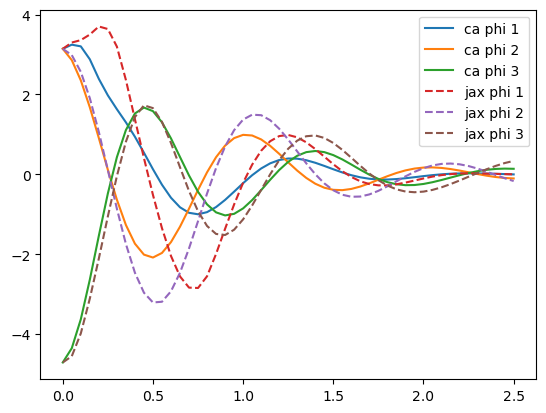

In [12]:
import matplotlib.pyplot as plt
print(casadi_sol.value(phi_1))
t = np.linspace(0,dt*horizon,horizon+1)
plt.figure(1)
plt.plot(t,casadi_phi_1,label='ca phi 1')
plt.plot(t,casadi_phi_2,label='ca phi 2')
plt.plot(t,casadi_phi_3,label='ca phi 3')

plt.plot(t,jax_phi_1,'--',label='jax phi 1')
plt.plot(t,jax_phi_2,'--',label='jax phi 2')
plt.plot(t,jax_phi_3,'--',label='jax phi 3')

# plt.figure(2)
# plt.plot(t[0:-1],sol.value(phi_1_m)[0:-1])
# plt.plot(t[0:-1],sol.value(phi_2_m)[0:-1])
# plt.figure(3)
# plt.plot(t[0:-1],sol.value(phi_m_1_set))
# plt.plot(t[0:-1],sol.value(phi_m_2_set))
plt.legend()
plt.show()



In [13]:
a=np.array([1,3,5])
b=np.array([2,4,6])
c=np.asanyarray([a,b]).reshape(-1,1)
print(c)
print(c[1:4:2])

[[1]
 [3]
 [5]
 [2]
 [4]
 [6]]
[[3]
 [2]]
